In [2]:
import geopandas as gpd
import requests
import time
import shapely
import geopandas_osm.osm
import numpy as np
import descartes as d
import math
%matplotlib notebook

<IPython.core.display.Javascript object>


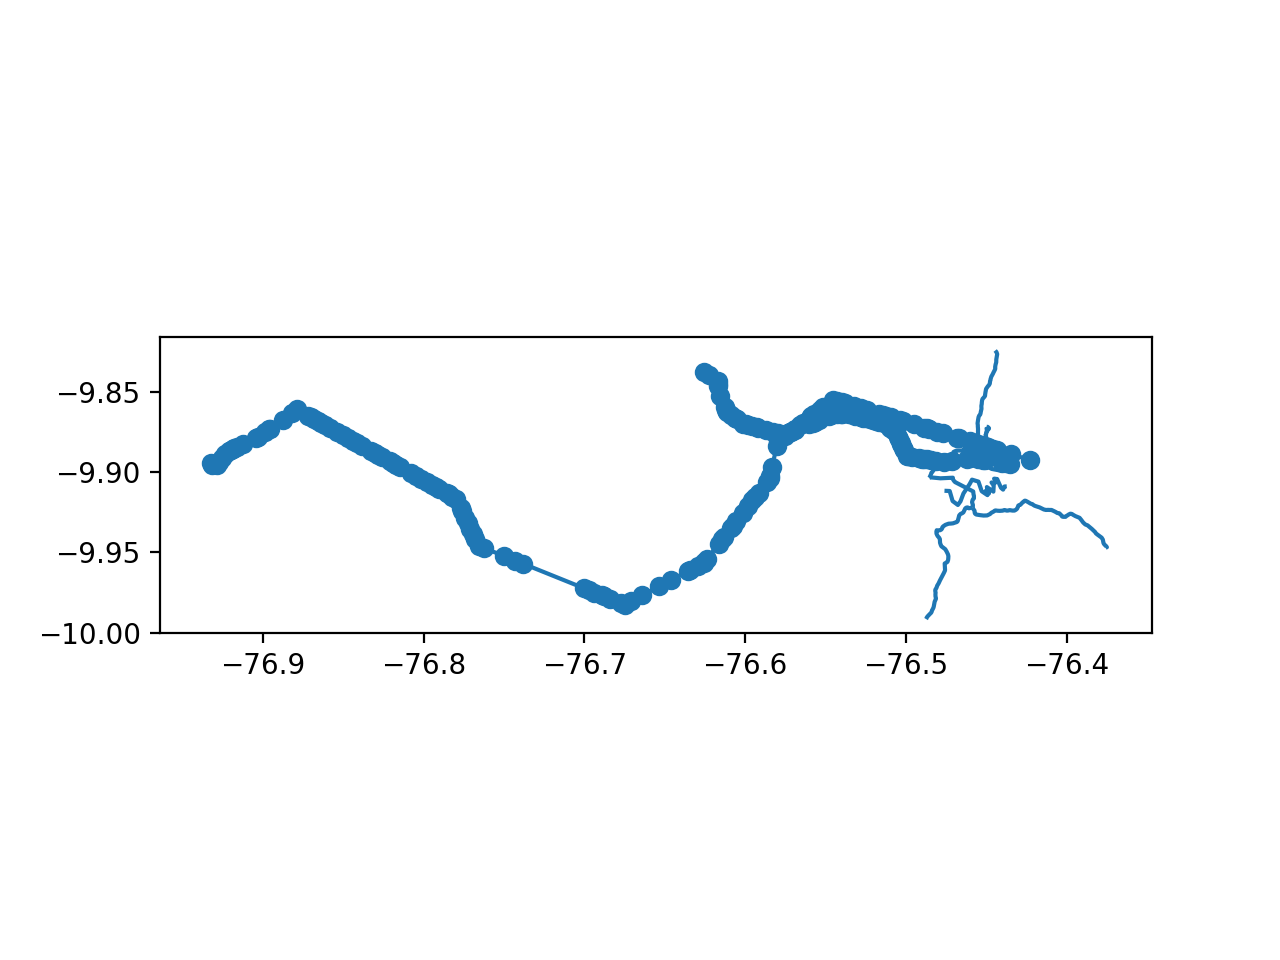

In [142]:
leftbound = -76.4592
rightbound = -76.4491
upperbound = -9.8721
lowerbound = -9.9383
bbox = [(leftbound,lowerbound ), (rightbound,lowerbound), (rightbound,upperbound), (leftbound,upperbound)]
poly = shapely.geometry.Polygon(bbox)
df = geopandas_osm.osm.query_osm('way', poly, recurse='down')
df.plot()

In [143]:
arr=["highway","residential", "primary", "secondary","tertiary","unclassified", "cycleway"]
df=df[df.highway.isin(arr)]
df["geometry"]


6    LINESTRING (-76.4493622 -9.872693999999999, -7...
7    LINESTRING (-76.4630418 -9.894894900000001, -7...
8    LINESTRING (-76.475937 -9.911633200000001, -76...
Name: geometry, dtype: object

In [178]:
newdata = gpd.GeoDataFrame()
newdata["street name"]=None
newdata["geometry"]=None
streetnewdata = gpd.GeoDataFrame()
streetnewdata["street name"]=None
streetnewdata["geometry"]=None

In [145]:
elevations = dict()

In [146]:
print elevations

{}


In [147]:
all_coords_list = []
for geometry in df["geometry"]:
    for coord in geometry.coords:
        all_coords_list.append(coord)

In [148]:
def is_intersection(val):
    num_matches = 0
    for i in all_coords_list:
        if val == i:
            num_matches +=1
    
    if(num_matches > 1):
        return True
    else:
        return False

def get_elev_diff(point1, point2):
        return get_elev(point1)-get_elev(point2)
def get_elev(point):
    if(point in elevations):
        return elevations[point]
    else:
        rqstring = "https://maps.googleapis.com/maps/api/elevation/json?locations="+str(point[0])+","+str(point[1])
        elevation=requests.get(rqstring)
        elev = elevation.json()["results"][0]["elevation"]
        elevations[point] = elev
        time.sleep(.1)
        return elev
def distance(point1, point2):
    return math.hypot(point2[0]-point1[0], point2[1]-point1[1])
def dot(a, b):
    return (a[0]*b[0])+(a[1]*b[1])
def get_vector(point, origin):
    return (point[0]-origin[0], point[1]-origin[1])
def get_anchor_point(point1, point2, elev_diff):
    xv = get_vector(point1, point2)[0]
    yv = get_vector(point1, point2)[1]
    anchor = (-yv, xv)
    anchor = [i*elev_diff/distance(point1, point2) for i in anchor] 
    return (point1[0]+anchor[0], point1[1]+anchor[1])

def get_baseline_angle(anchor, other):
    return math.atan((other[1]-anchor[1])/(other[0]-anchor[0]))



In [149]:
get_anchor_point((2.47,2.9),(1.23, 2.37), 0)

(2.47, 2.9)

In [150]:
projection_anchor = (1.23, 2.37)
project_point = (2,4)
project_end = (5,4)
a = get_vector(projection_anchor, project_point)
b = get_vector(projection_anchor,project_end)
print projection_anchor[0]-a[0],projection_anchor[1]-a[1]
print projection_anchor[0]-b[0],projection_anchor[1]-b[1]
print a, b
try:
    c = dot(a, b)/dot(b,b)
    print c
except:
    c = 0
    print a, b, elev_diff
    print "Zero division"
c = (c*b[0], c*b[1])
p = (projection_anchor[0]-c[0], projection_anchor[1]-c[1])
print "p: ", p

2.0 4.0
5.0 4.0
(-0.77, -1.63) (-3.77, -1.63)
0.32957118638
p:  (2.472483372654092, 2.907201033800045)


In [208]:
new_index = -1
for index, geometry in zip(df.index.values, df["geometry"]):
    new_index +=1
    coords = geometry.coords
    coords_list = [i for i in coords]
    intersection_list = [0]
    index=1
    for coord in coords[1:-1]:
        if(is_intersection(coord)):
            intersection_list.append(index)
        index+=1
    intersection_list.append(int(len(coords)-1))

    prev_index = 0    
    print len(intersection_list)
    if(len(intersection_list) >= 2):
        if(len(intersection_list) == 2):
            point1 = coords[0]
            point2 = coords[-1]
            elev1 = get_elev(point1)
            elev2 = get_elev(point2)
            elev_diff=round((elev1-elev2)*.001,7)
            baseline_angle = 0
            anchor_point = get_anchor_point(point1, point2, elev_diff)
            print(elev_diff)
            if(elev_diff > 0):
                anchor_point = get_anchor_point(point2, point1, elev_diff)
                point1, point2 = point2, point1
            elif(elev_diff == 0):
                anchor_point = point1
            else:
                baseline_angle = get_baseline_angle(anchor_point, point2)
            seg_arr = coords_list[1:-1]
            new_points = []
            #new_points.append(anchor_point)
            new_points.append(point1)
            projection_anchor = point1
            project_end = point2
            for point in seg_arr[1:-1]:
                a = get_vector(point, anchor_point)
                b = get_vector(point2, anchor_point)
                project_point = point
                a = get_vector(projection_anchor, project_point)
                b = get_vector(projection_anchor,project_end)
                try:
                    c = dot(a, b)/dot(b,b)
                except:
                    c = 0
                    print a, b, elev_diff
                    print "Zero division"
                c = (c*b[0], c*b[1])
                p = (projection_anchor[0]-c[0], projection_anchor[1]-c[1])
                cur_point_elev_diff = elev_diff=round((get_elev(point)+min(elev1, elev2))*.001,7)
                p_with_elev_diff = get_anchor_point(p,project_end, cur_point_elev_diff)
                #print "p: ", p
                new_points.append(p_with_elev_diff)
                #new_points.append(p)
            new_points.append(point2)
            seg_arr = new_points
        else:
            for i in intersection_list[1:-1]:
                #print "section from point ", coords[prev_index], "to point", coords[i], ":",
                point1 = coords[prev_index]
                point2 = coords[i]
                elev1 = get_elev(point1)
                elev2 = get_elev(point2)
                elev_diff=round((elev1-elev2)*.001,7)
                baseline_angle = 0
                anchor_point = get_anchor_point(point1, point2, elev_diff)
                print(elev_diff)
                if(elev_diff >0):
                    anchor_point = get_anchor_point(point2, point1, elev_diff)
                    point1, point2 = point2, point1
                elif(elev_diff == 0):
                    anchor_point = point1
                if(anchor_point == False):
                    anchor_point = point1
                else:
                    baseline_angle = get_baseline_angle(anchor_point, point2)
                seg_arr = coords_list[prev_index:i]
                new_points = []
                new_points.append(anchor_point)
                new_points.append(point1)
                projection_anchor = point1
                project_end = point2
                for point in seg_arr[1:-1]:
                    a = get_vector(point, anchor_point)
                    b = get_vector(point2, anchor_point)
                    project_point = point
                    a = get_vector(projection_anchor, project_point)
                    b = get_vector(projection_anchor,project_end)
                    try:
                        c = dot(a, b)/dot(b,b)
                    except:
                        c = 0
                        print a, b, elev_diff
                        print "Zero division"
                    c = (c*b[0], c*b[1])
                    p = (projection_anchor[0]-c[0], projection_anchor[1]-c[1])
                    cur_point_elev_diff = elev_diff=round((get_elev(point)+min(elev1, elev2))*.001,7)
                    p_with_elev_diff = get_anchor_point(p,project_end, cur_point_elev_diff)
                    #print "p: ", p
                    new_points.append(p_with_elev_diff)
                    #new_points.append(p)
                new_points.append(point2)
                seg_arr = new_points
                prev_index = i

    else:
        elev_diff=round(get_elev_diff(coords[0], coords[1])*.0001,7)
        seg_arr = coords_list  
        anchor = get_anchor_point(coords[0],coords[1], elev_diff)
        seg_arr.append(anchor)
    #print seg_arr
    if(len(seg_arr) > 2):
        poly = shapely.geometry.Polygon(seg_arr)
        line = shapely.geometry.LineString(seg_arr[:-1]).buffer(0.00001)
        try:
            streetnewdata.loc[new_index, "geometry"] = line
            streetnewdata.loc[new_index, "street name"] = name
            newdata.loc[new_index, "geometry"] = poly
            newdata.loc[new_index, "street name"] = name
        except:
            continue

2
5.66e-05
2
-0.0078977
2
-0.0098423


<IPython.core.display.Javascript object>


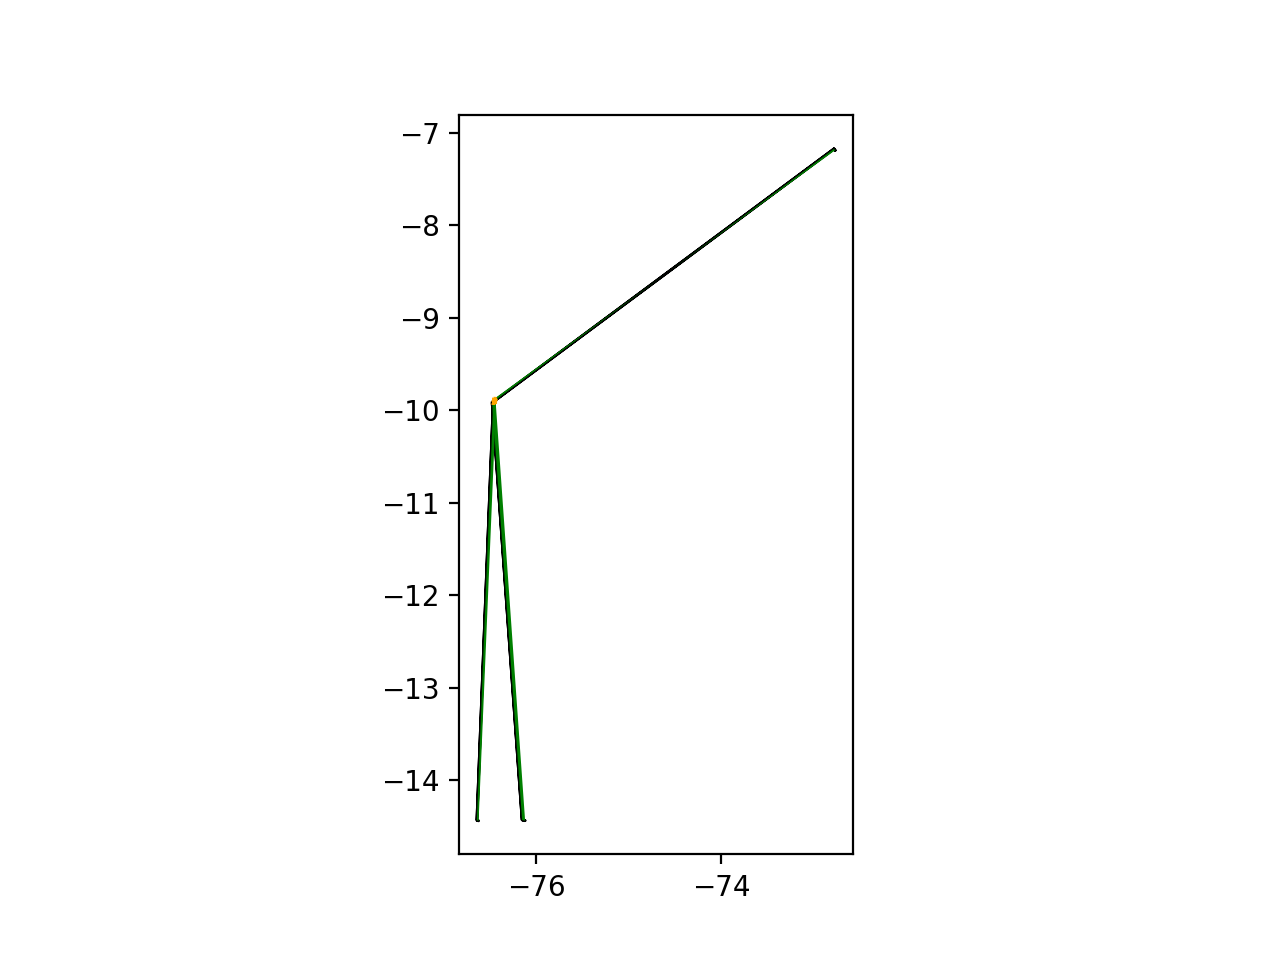

In [209]:
base = streetnewdata.plot(color='white', edgecolor='black')
newdata.plot(ax=base, color='green');
df.plot(ax=base, color="orange")

,street name,geometry


In [ ]:
newdata.to_file("out_map.shp")
streetnewdata.to_file("out_street_map.shp")
